# <center>**实战实验报告 —— 新闻分类**</center>
<hr></hr>  

### <center></center>
 **<center>控制科学与工程学院&emsp;3200100259&emsp;沈骏一</center>**<br>
 **<center>电气工程学院&emsp;3200104139&emsp;朱语</center>** <br> 
 **<center>控制科学与工程学院&emsp;3200105210&emsp;宋孟炫</center>**  

#### **摘要**
在本次实验中，我们尝试采用Textcnn+word2vet方法以及改进的BERT方法对给定的新闻分类选题进行了探究。经过数据预处理、字典解析、模型的搭建与训练等步骤，我们搭建的模型在训练集、验证集与测试集上都达到了98%的良好效果，同时在平台的测试上也达到了90+的优良成绩。我们还对字典构成等方面做出改善，期待更一步的提升。<br>

#### **关键词:**
自然语言处理、TextCNN、BERT、神经网络

# <center>final project —— news classification</center>

**Abstract**<br>
In this research, we tried several methods for the mission of news classification, including word2vec+textcnn and BERT, etc, most of which are modern state-of-the-art technique in NLP domain. We establish our model via data pre-processing, vocabulary-table analysis, model building and training, and it eventually reach a score of over 98% among train-set, validation-set and test-set. The final accuracy tested by the MO platform show a score of approximately 90. We’ve made some improvement on the vocabulary-table, which is promising yet not tested.<br>
<br>
**Key Words:**<br>
NLP, textcnn, bert, AI

----

# 1. 写在前面

### 1.1 项目背景

自媒体的出现，让网络上各类文章的数量大大增加。现在有一家自媒体平台收到了大量投稿，试开发一个机器学习模型来对这些新闻稿件进行分类，降低工作人员的负担。

### 1.2 题目要求

1. 任务提供包括数据读取、基础模型、模型训练等基本代码  
2. 参赛选手需完成核心模型构建代码，并尽可能将模型调到最佳状态  
3. 模型单次推理时间不超过 10 秒  

### 1.3 任务描述

训练AI基于给定新闻素材判断新闻类型，可选类别包括：科技，社会， 娱乐， 财经， 体育

# 2. TextCNN概述

Yoon Kim在2014年 “Convolutional Neural Networks for Sentence Classification” 论文中提出TextCNN（利用卷积神经网络对文本进行分类的算法）<br>
<img src='./doc/textcnn_struct.png' style="zoom:60%"><br>
CNN需要对输入样本进行卷积操作，对于文本数据，filter不再横向滑动，仅仅是向下移动，有点类似于N-gram在提取词与词间的局部相关性。图中共有三种步长策略，分别是2,3,4，每个步长都有两个filter（实际训练时filter数量会很多）。在不同词窗上应用不同filter，最终得到6个卷积后的向量。然后对每一个向量进行最大化池化操作并拼接各个池化值，最终得到这个句子的特征表示，将这个句子向量丢给分类器进行分类，至此完成整个流程。


# 3. word2vec概述

Word2vec，是一群用来产生词向量的相关模型。这些模型为浅而双层的神经网络，用来训练以重新建构语言学之词文本。网络以词表现，并且需猜测相邻位置的输入词，在word2vec中词袋模型假设下，词的顺序是不重要的。训练完成之后，word2vec模型可用来映射每个词到一个向量，可用来表示词对词之间的关系。

<img src="./doc/w2v.png" >

# 4. w2v+textcnn方法实现

### 4.1 数据导入及分词预处理

In [1]:
# 导入相关包
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import time
import random
import jieba as jb
import numpy as np
import jieba.analyse
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import gensim
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models.word2vec import LineSentence

from tqdm import tqdm
from time import time

2022-12-29 00:31:41.977869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 00:31:42.201824: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-29 00:31:43.072321: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-29 00:31:43.072445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
dataset = {}
dataset_path = "./datasets/"
files= os.listdir(dataset_path)
for file in files:
    path = os.path.join(dataset_path, file)
    if not os.path.isdir(path) and not file[0] == '.': # 跳过隐藏文件和文件夹
        f = open(path, 'r',  encoding='UTF-8') # 打开文件
        for line in f.readlines():
            dataset[line] = file[:-4]


In [3]:
# 读取数据和标签
def load_data(dataset_path):
    """
    :param dataset_path:数据集文件夹路径
    :return:返回读取的片段和对应的标签
    """
    sentences = [] # 新闻文本
    target = [] # 类别
    
    # 定义label到数字的映射关系
    labels = {'科技': 0, '社会': 1, '娱乐': 2, '财经': 3, '体育': 4}

    files = os.listdir(dataset_path)
    for file in files:
        path = os.path.join(dataset_path, file)
        if not os.path.isdir(path) and not file[0] == '.':
            with open(path, 'r', encoding='UTF-8') as f: # 打开文件
                for line in f.readlines():
                    sentences.append(line)
                    target.append(labels[file[:-4]])

    target = np.array(target)
    encoder = LabelEncoder()
    encoder.fit(target)
    encoded_target = encoder.transform(target)
    dummy_target = to_categorical(encoded_target)
    return sentences, dummy_target


# 对读取的片段进行分词，由于分词后的片段任然为中文词语组成的序列，需要创建词汇表，将每个中文词映射为一个数字。这里使用 Tensorflow 的 Tokenizer 创建词汇表。
def padding(text_processed, max_sequence_length):
    """
    数据处理，如果使用 lstm，则可以接收不同长度的序列（这里不用lstm，只做等长处理）
    :text_processed：不定长的 Token 化文本序列，二维list
    :path：数据集路径
    :max_sequence_length：padding 大小，长句截断短句补 0
    :return 处理后的序列，numpy 格式的二维数组
    """
    res = []
    for text in text_processed:
        if len(text) > max_sequence_length:
            text = text[:max_sequence_length]
        else:
            text = text + [0 for i in range(max_sequence_length-len(text))]
        res.append(text)
    return np.array(res)

In [13]:
# 过滤停用词和空格
stop_words = 'cn_stopwords.txt'
pos = ('n', 'nz', 'v', 'ns', 'vn', 'i', 'a', 'nt', 'b', 'vd', 't', 'ad', 'an', 'c', 'nr')
blocks = ['\ax0', '\u3000', '\n', '\t', ' ']
stopwords = {}.fromkeys([line.rstrip() for line in open(stop_words,
                                                        encoding='utf-8')])
jieba.analyse.set_stop_words(stop_words)


# 过滤停用词
def jieba_split(sentences, num=0):
    sentences = [jb.lcut(t, cut_all=False) for t in sentences]
    new_sentences = []
    for sentence in sentences:
        result = []
        for word in sentence:
            if word not in stopwords and word not in blocks:
                result.append(word)
        sentence = " ".join(word for word in result)
        if num != 0:
            new_sentences.append(
                " ".join(jieba.analyse.extract_tags(
                    sentence, 
                    topK=num, 
                    withWeight=False, 
                    allowPOS=pos)
                    )
            )
        else:
            new_sentences.append(sentence)
    return new_sentences

In [ ]:
dataset_path = "./datasets/"
# 查看我们创建词汇表的结果
sentences,target = load_data(dataset_path)

#定义是文档的最大长度。如果文本的长度大于最大长度，那么它会被剪切，反之则用0填充
max_sequence_length = 80

# 分词，并提取关键的80个keyword
sentences = jieba_split(sentences, max_sequence_length)

In [ ]:
# 保存分词结果
np.save('./results/sentence', sentences)
np.save('./results/target', target)

In [4]:
# 调用存储过的sentences和target
sentences = np.load('./results/sentence.npy')
target = np.load('./results/target.npy')

通过分词和按词性选取，可以看到文字的密度和信息量增大了

In [6]:
print(sentences[0])

比赛 宏远队 系列赛 阿迪江 球队 梦游 今晚 季后赛 控球 昨天 后卫 训练 惨败 不会 宁波 队医 赛点 合练 上场比赛 苏伟 阿的江 冯爱军 张骋宇 扭伤脚 杜锋 后场 扭伤 雅戈尔 帕克 本赛季 信息时报 再犯 岌岌可危 水平 拉开序幕 特例 赛事 缺席 败仗 体育馆 主帅 低级 方面 回合 适应性 半小时 东莞 打出 分水岭 解开 失误 队员 认为 好看 拿到 环节 跟随 差距 厉害 脖子 落后 前景 错误 正好 年轻 失去 观察 晚上 是因为 双方 强调 全面 状态 接受 参加 今天 控制 看到 分析 要求


**Tokenizer** 类允许使用两种方法向量化一个文本语料库： 将每个文本转化为一个整数序列（每个整数都是词典中标记的索引）； 或者将其转化为一个向量，其中每个标记的系数可以是二进制值、词频、TF-IDF权重等。

In [5]:
# 定义是文档的最大长度。如果文本的长度大于最大长度，那么它会被剪切，反之则用0填充
max_sequence_length = 80

# 如果之前已经生成了词汇表，就不用在重复生成了，直接从文件中加载词汇表
vocab_json_string = ""
vocab_keras_path = "results/vocab_keras_800.json"
with open(vocab_keras_path) as f:
    vocab_json_string = f.read()
print("加载词汇表、序列化")
vocab_processor = tf.keras.preprocessing.text.tokenizer_from_json(vocab_json_string)
# 词序列的列表，将 sentences 文本序列化
text_processed = vocab_processor.texts_to_sequences(sentences)
# 将句子 padding 为固定长度，如果使用lstm则不需要 padding 为固定长度
text_processed = padding(text_processed, max_sequence_length)


加载词汇表、序列化


### 4.2 划分训练集、验证集，训练word2vec模型

定义dataloader、划分数据集

In [ ]:
class MyDataSet(Dataset):
    def __init__(self, x_data: np.ndarray, y_data: np.ndarray):
        self.x_data = torch.from_numpy(x_data)
        self.y_data = torch.from_numpy(y_data)
        self.len = x_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [ ]:
# 验证集比例
val_split = 0.15
# 批次大小
batch_size = 32

# 打乱顺序
print("切分数据")
text_target = list(zip(text_processed, target))
# print(text_target)
random.shuffle(text_target)
text_processed[:], target[:] = zip(*text_target)
text_processed[:], target[:] = zip(*text_target)

# 验证集数目
val_counts = int(val_split * len(text_target))

# 切分验证集
val_X = text_processed[-val_counts:]
val_y = target[-val_counts:]
train_X = text_processed[:-val_counts]
train_y = target[:-val_counts]
print("数据切分完成")

train_set = MyDataSet(train_X, train_y)
val_set = MyDataSet(val_X, val_y)

train_iter = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_iter = DataLoader(val_set, batch_size=batch_size, shuffle=True)

采用gensim库model模块中的word2vec库，设定词向量的映射维度100维

In [ ]:
from gensim.models.word2vec import Word2Vec
num_feature = 100   # 向量维度
num_worker = 4

model = Word2Vec(
    sentences=sentences, 
    workers=num_worker, 
    vector_size=num_feature
    )
model.init_sims(replace=True)
save_path = './results/w2v.bin'
model.save(save_path)

### 4.3 搭建textcnn模型并训练

定义模型<br>
textcnn是一种用于文字处理的cnn，将文本数字序列化利用不同宽度的卷积核进行计算，得到的结果合并用于信息分类

In [7]:
dtype = torch.FloatTensor
w2v = Word2Vec.load("./results/w2v.bin")

# Text-CNN Parameter
embedding_size = 100
sequence_length = 80
num_classes = 5
filter_sizes = [2, 3, 4]  # n-gram window
num_filters = 3
vocab_size = 800


class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()

        self.num_filters_total = num_filters * len(filter_sizes)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        # 导入word2vec训练的权重参数
        self.embedding.weight = nn.Parameter(torch.tensor(w2v.wv.vectors))
        # 并列的卷积块，包括卷积、活化和池化
        self.convs = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(1, num_filters, (filter_size, embedding_size), bias=True),
                    nn.LeakyReLU(),
                    nn.MaxPool2d((sequence_length - filter_size + 1, 1)),
                )
                for filter_size in filter_sizes
            ]
        )
        # 展平用于分类
        self.linear = nn.Linear(self.num_filters_total, num_classes)

    def forward(self, X):
        embedded_chars = self.embedding(X)
        embedded_chars = embedded_chars.unsqueeze(1)  
        h_pool = torch.cat(
            [conv(embedded_chars).permute(0, 3, 2, 1) for conv in self.convs],
            len(filter_sizes),
        )  # [batch_size, output_height(=1), output_width(=1), output_channel(=3) * 3]
        h_pool_flat = torch.reshape(
            h_pool, [-1, self.num_filters_total]
        )  # [batch_size, output_height * output_width * (output_channel * 3)]
        model = self.linear(h_pool_flat)
        return model

In [8]:
print("使用设备：")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

print("加载模型")
model = TextCNN()
model = model.to(device=device)

使用设备：
cuda
加载模型


查看模型结构，可以看到嵌入层、并列卷积块、全连接层

In [9]:
print(model)

TextCNN(
  (embedding): Embedding(800, 100, padding_idx=0)
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 3, kernel_size=(2, 100), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=(79, 1), stride=(79, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(1, 3, kernel_size=(3, 100), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=(78, 1), stride=(78, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(1, 3, kernel_size=(4, 100), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=(77, 1), stride=(77, 1), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (linear): Linear(in_features=9, out_features=5, bias=True)
)


定义训练方法

In [ ]:
# Training
def train_model(
    device,
    train_iter,
    val_iter,
    epochs=50,
    lr=3e-3,
    model_save_path="results/temp/",
    log_dir="results/logs/",
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", factor=0.25, patience=5
    )
    loss_list = []
    val_best_loss = 1e5
    model.train()
    for epoch in tqdm(range(epochs)):
        best_loss = 1e5
        start = time()
        # train
        for _, (X, y) in enumerate(train_iter):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            if loss < best_loss:
                best_loss = loss
            optimizer.step()
        loss_list.append(best_loss)
        span = time() - start
        print(
            f"train || epoch {epoch+1} || loss(best) {best_loss} || lr = {optimizer.state_dict()['param_groups'][0]['lr']} || time {span}s"
        )

        # evaluate
        best_loss = 1e5
        model.eval()
        start = time()
        acc = 0
        total = 0
        with torch.no_grad():
            for _, (X, y) in enumerate(val_iter):
                X = X.to(device)
                y = y.to(device)
                output = model(X)
                loss = criterion(output, y)
                if loss < best_loss:
                    best_loss = loss

                y_hat = output.cpu().numpy()
                y = y.cpu().numpy()
                for i in range(y.shape[0]):
                    total += 1
                    if np.argmax(y[i]) == np.argmax(y_hat[i]):
                        acc += 1

            acc = acc * 100.0 / total

            scheduler.step(best_loss)
            if best_loss < val_best_loss:
                val_best_loss = best_loss
            if acc > 99:
                torch.save(
                    model.state_dict(), model_save_path + f"{epoch+1}_{best_loss}.h5"
                )
        span = time() - start
        print(
            f"eval  || epoch {epoch+1} || loss(best) {best_loss} || acc {acc} || lr = {optimizer.state_dict()['param_groups'][0]['lr']} || time {span}s"
        )
        print()

    torch.save(model.state_dict(), model_save_path + "model.h5")

    return loss_list

In [ ]:
print("开始训练===>")
loss_list = train_model(device, epochs=45, train_iter=train_iter, val_iter=val_iter)
loss_list = torch.tensor(loss_list).cpu()
save_path = "./results/loss_list"
np.save(save_path, loss_list.numpy())

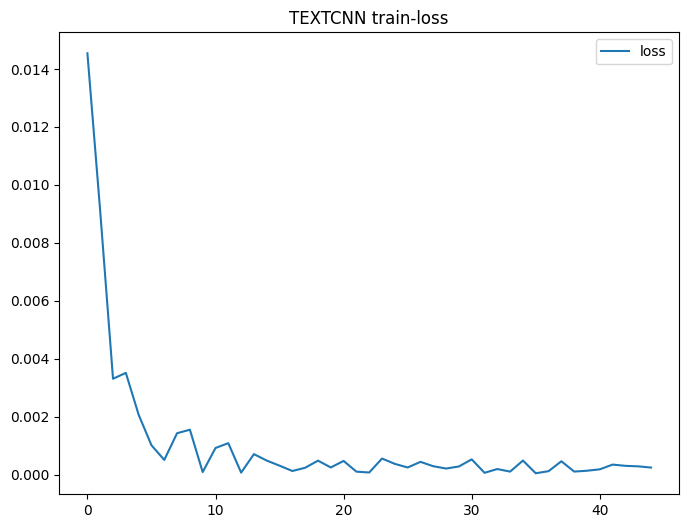

In [10]:
save_path = "./results/loss_list.npy"
loss_list = np.load(save_path)
plt.figure(figsize=(8, 6))
plt.plot(loss_list,label = "loss")
plt.title('TEXTCNN train-loss')
plt.legend()
plt.show()

### 4.4 进行模型预测

In [11]:
# 预测某一篇新闻
def predict(text):
    """
    :param text: 中文字符串
    :return: 字符串格式的类型，比如:'科技'
    """
    sentence = []
    labels = {0: "科技", 1: "社会", 2: "娱乐", 3: "财经", 4: "体育"}
    sentence.append(text)
    sen_prosessed = jieba_split(sentences=sentence)[0]
    length = 80
    sen_prosessed = vocab_processor.texts_to_sequences([sen_prosessed])[0]
    sen_prosessed = padding([sen_prosessed], length)[0]
    sen_prosessed = torch.tensor(sen_prosessed).view(1, -1).to(device)

    # 加载模型进行预测
    with torch.no_grad():
        model.eval()
        result = model(sen_prosessed)
        result = result.cpu()

    result = result.numpy()

    prediction = labels[np.argmax(result[0])]
    # --------------------------------------------------------------------------

    return prediction

In [15]:
print("开始预测====>")
model = TextCNN()
model.load_state_dict(torch.load('./results/temp/model.h5'))
model = model.to(device=device)
val_sentence = "跨国公司欲抄底中国芯片设计产　　孙燕　　在全球半导体行业困境面前，国际半导体巨头将矛头瞄准了本土半导体设计企业　　日前，《第一财经日报》从可靠途径获悉，美国Aptina近日已经悄然并购了上海智多微电子公司的手机软件平台设计部门　　上海智多微电子公司一位内部员工证实了这一消息，该内部员工表示，由于自己也正在办理离职手续，交易金额并未宣布　　成立于2003年9月的智多微电子主要从事移动多媒体应用处理芯片和手机平台解决方案的研发，目前已经开发出9款多媒体应用处理器。智多微电子董事长兼CEO胡祥在去年10月还曾对媒体表示，智多微电子正在试图降低智能手机入市门槛。龙旗、希姆通、天宇朗通、夏新、天时达等16家国产手机厂家都曾是智多微电子的客户　　而Aptina公司是美光科技有限公司2008年初才成立的子公司，为手机制造商提供200万、300万和500万像素CMOS图像传感器，是CMOS成像行业的领先企业　　“智多手机软件平台部门的员工数大概在30人至40人，这部分员工应该会全部转到Aptina公司。”知情人士透露，此前智多微电子的员工数多达200人，今年逐步缩减到100人左右　　该知情人士指出，智多微电子竞争对手联发科技(MTK)手机芯片功能越来越强大，蚕食了智多微电子的客户和其生存空间　　“目前国内很多半导体芯片企业都很缺钱，受金融风暴影响，融资渠道基本关闭。”业内一位资深分析人士指出，虽然中国集成电路产业发展20多年，但至今营业额达到1亿美元的公司很少　　“从2007年10月到2008年的10月，总共有4家本土IC设计公司被外国公司收购，2009年这种并购案例还会增加。”iSuppli中国半导体行业分析师顾文军指出，随着现在资本市场的低迷，而中国半导体上市公司在美国纳斯达克表现均不佳，并购则成了公司的一种出路。被并购的4家本土IC设计公司为：上海杰脉、杭州晶圆微芯、深圳原核、成都威斯达。　　相关报道　　寒流袭来：中国芯片业熬　　2011年中国芯片市场将达2000亿　　美股评论：全球芯片业濒临绝"
result = predict(text=val_sentence)
print(f"预测结果：{result} || 真实为：科技")

开始预测====>
预测结果：科技 || 真实为：科技


最终textcnn的模型预测准确率在85%上下<br>
<img src='doc/textcnn.png' stype="zoom:80%">

# 5. BERT模型概述


BERT的全称为Bidirectional Encoder Representation from Transformers，是一个预训练的语言表征模型。它强调了不再像以往一样采用传统的单向语言模型或者把两个单向语言模型进行浅层拼接的方法进行预训练，而是采用新的masked language model（MLM），以致能生成深度的双向语言表征。  
BERT论文发表时提及在11个NLP（Natural Language Processing，自然语言处理）任务中获得了新的state-of-the-art的结果，令人目瞪口呆。   
而BERT利用MLM进行预训练并且采用深层的双向Transformer组件来构建整个模型，最终生成能融合左右上下文信息的深层双向语言表征。  
![Alt text](doc/Screenshot%20from%202022-12-30%2012-22-58.png)

BERT的输入为每一个token对应的表征，实际上该表征是由三部分组成的，分别是对应的token，分割和位置 embeddings。   
![Alt text](doc/Screenshot%20from%202022-12-30%2012-23-44.png)  
Transformer的特点就是有多少个输入就有多少个对应的输出。

Whole Word Masking (wwm)，暂翻译为全词Mask或整词Mask，是谷歌在2019年5月31日发布的一项BERT的升级版本，主要更改了原预训练阶段的训练样本生成策略。 简单来说，原有基于WordPiece的分词方式会把一个完整的词切分成若干个子词，在生成训练样本时，这些被分开的子词会随机被mask。   
在全词Mask中，如果一个完整的词的部分WordPiece子词被mask，则同属该词的其他部分也会被mask，即全词Mask。

由于笔者水平限制，对于Bert模型还没有充分的理解。详情可参见论文  
`《Attention is all you need》`  
`《Pre-Training with Whole Word Masking for Chinese BERT》`

# 6. BERT主干网络搭建


首先，加载实验所需要的包：

In [18]:
import pandas as pd 
import numpy as np 
import json, time 
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel, BertConfig, BertTokenizer, AdamW, get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')

在本次实验探究中，我们选择采用`BERT`模型完成新闻的分类工作   
在经过多次的试验后，我们选择了`HFL`实验室的`RBT3`模型进行新闻的推断工作  
其余模型的结果在之后模块中呈现

In [19]:
#从Transformer包中加载模型
model_name = 'hfl/rbt3'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at hfl/rbt3 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


采用测试句子查看BERT层的输入输出结构

In [15]:
sen = 'Transformers提供了NLP领域大量state-of-art的 预训练语言模型结构的模型和调用框架。'
inputs = tokenizer(sen, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(inputs)
print(tokens)
outputs = model(**inputs)
print(len(outputs))
print(outputs[0].shape, outputs[1].shape)

{'input_ids': tensor([[  101,   162, 10477,  8118, 12725,  8755,  2990,   897,   749,   156,
         10986,  7566,  1818,  1920,  7030, 10223,   118,  8205,   118,  9143,
          4638,  7564,  6378,  5298,  6427,  6241,  3563,  1798,  5310,  3354,
          4638,  3563,  1798,  1469,  6444,  4500,  3427,  3373,   511,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
['[CLS]', 't', '##ran', '##s', '##form', '##ers', '提', '供', '了', 'n', '##lp', '领', '域', '大', '量', 'state', '-', 'of', '-', 'art', '的', '预', '训', '练', '语', '言', '模', '型', '结', '构', '的', '模', '型', '和', '调', '用', '框', '架', '。', '[SEP]']
2
torch.Size([1, 40, 768]) torch.Size([1, 768])


上述表明了模型的划分方法主要是单字，这位之后模型优化提供了空间。

对数据进行处理，主要步骤有：
1. 设定最大词长为100，不足则补空格
2. 删去开头结尾的空格，并用`Unicodedata`包进行NFKC方法规范化
3. 放入Tokenizer进行编码
4. 以8：1：1的比例划分成为训练集、验证集和测试集

In [ ]:
import unicodedata

data_nums = []
maxlen = 120    

train_input_ids, train_input_masks, train_input_types, train_labels = [], [], [] ,[] # input char ids, segment type ids,  attention mask
valid_input_ids, valid_input_masks, valid_input_types, valid_labels = [], [], [] ,[] # input char ids, segment type ids,  attention mask
test_input_ids, test_input_masks, test_input_types, test_labels = [], [], [] ,[] # input char ids, segment type ids,  attention mask

In [ ]:
def encode(file_path:str, label:int):
    with open(file_path, encoding='utf-8') as f:
        input_ids, input_masks, input_types, labels = [], [], [] ,[] # input char ids, segment type ids,  attention mask
        for i, line in tqdm(enumerate(f)): 
            content = unicodedata.normalize('NFKC', line.strip())
            # encode_plus会输出一个字典，分别为'input_ids', 'token_type_ids', 'attention_mask'对应的编码
            # 根据参数会短则补齐，长则切断
            content = jieba_split_singleline(content)
            encode_dict = tokenizer.encode_plus(text=content, max_length = maxlen, 
                                                padding='max_length', truncation=True)
            input_ids.append(encode_dict['input_ids'])
            input_types.append(encode_dict['token_type_ids'])
            input_masks.append(encode_dict['attention_mask'])
        
            labels.append([1 if x == label-1 else 0 for x in range(5)])
        
        train_input_ids.extend(np.array(input_ids[:int(i*0.8)]))
        train_input_types.extend(np.array(input_types[:int(i*0.8)]))
        train_input_masks.extend(np.array(input_masks[:int(i*0.8)]))
        train_labels.extend(np.array(labels[:int(i*0.8)]))    
        valid_input_ids.extend(np.array(input_ids[int(i*0.8):int(i*0.8)+int(i*0.1)]))
        valid_input_types.extend(np.array(input_types[int(i*0.8):int(i*0.8)+int(i*0.1)]))
        valid_input_masks.extend(np.array(input_masks[int(i*0.8):int(i*0.8)+int(i*0.1)]))
        valid_labels.extend(np.array(labels[int(i*0.8):int(i*0.8)+int(i*0.1)]))
        test_input_ids.extend(np.array(input_ids[int(i*0.8)+int(i*0.1):]))
        test_input_types.extend(np.array(input_types[int(i*0.8)+int(i*0.1):]))
        test_input_masks.extend(np.array(input_masks[int(i*0.8)+int(i*0.1):]))
        test_labels.extend(np.array(labels[int(i*0.8)+int(i*0.1):]))
        data_nums.append(i+1)

In [ ]:
encode("./datasets/体育.txt", label=1)
encode("./datasets/娱乐.txt", label=2)
encode("./datasets/社会.txt", label=3)
encode("./datasets/科技.txt", label=4)
encode("./datasets/财经.txt", label=5)

print(data_nums)

经过以上操作，我们得到了5*10000共五万规模的数据集，接下来建立Dataloader对象

In [13]:
BATCH_SIZE = 64  # 如果会出现OOM问题，减小它
# 训练集
train_data = TensorDataset(torch.LongTensor(train_input_ids), 
                           torch.LongTensor(train_input_masks), 
                           torch.LongTensor(train_input_types), 
                           torch.LongTensor(train_labels))
train_sampler = RandomSampler(train_data)  
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# 验证集
valid_data = TensorDataset(torch.LongTensor(valid_input_ids), 
                          torch.LongTensor(valid_input_masks),
                          torch.LongTensor(valid_input_types), 
                          torch.LongTensor(valid_labels))
valid_sampler = SequentialSampler(valid_data)
valid_loader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)
# 测试集（是没有标签的）
test_data = TensorDataset(torch.LongTensor(test_input_ids), 
                          torch.LongTensor(test_input_masks),
                          torch.LongTensor(test_input_types))
test_sampler = SequentialSampler(test_data)
test_loader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

定义模型结构:从BERT模型出来后经过全连接层对应五种分类类别：   
再通过Softmax层转化成对应概率

In [5]:
# 定义model
class Bert_Model(nn.Module):
    def __init__(self,classes=10):
        super(Bert_Model,self).__init__()
        self.model_name = 'hfl/rbt3'
        self.bert = BertModel.from_pretrained(self.model_name)
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.fc = nn.Linear(768,5)     #全连接层
        self.softmax = nn.Softmax()
        
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)
        out_pool = outputs[1]   # 池化后的输出 [bs, config.hidden_size]
        out = self.fc(out_pool)   #  [bs, classes]
        out = self.softmax(out)
        return out

打印对应的模型参数

In [8]:
def get_parameter_number(model):
    #  打印模型参数量
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return 'Total parameters: {}, Trainable parameters: {}'.format(total_num, trainable_num)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = 'cpu'         #用cpu进行训练
model = Bert_Model().to(DEVICE)
print(get_parameter_number(model))

Some weights of the model checkpoint at hfl/rbt3 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total parameters: 38480645, Trainable parameters: 38480645


建立优化器结构，设定epoch

In [11]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4) #AdamW优化器
EPOCHS = 5
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_loader),
                                            num_training_steps=EPOCHS*len(train_loader))
# 学习率先线性warmup一个epoch，然后cosine式下降。
# 加warmup（学习率从0慢慢升上去），如果把warmup去掉，可能收敛不了。

编写对应的训练、评估、测试函数

In [7]:
# 评估模型性能，在验证集上
def evaluate(model, data_loader, device):
    model.eval()
    val_true, val_pred = [], []
    with torch.no_grad():
        for idx, (ids, att, tpe, y) in (enumerate(data_loader)):
            y_pred = model(ids.to(device), att.to(device), tpe.to(device))
            y_pred = torch.argmax(y_pred, dim=1).detach().cpu().numpy().tolist()
            val_pred.extend(y_pred)
            val_true.extend(torch.argmax(y, dim=1).cpu().numpy().tolist())
    
    return accuracy_score(val_true, val_pred)  #返回accuracy


# 测试集没有标签，需要预测提交
def predict(model, data_loader, device):
    model.eval()
    val_pred1,val_pred2,val_pred3,val_pred4,val_pred5 = [],[],[],[],[]
    with torch.no_grad():
        for idx, (ids, att, tpe) in tqdm(enumerate(data_loader)):
            y_pred = model(ids.to(device), att.to(device), tpe.to(device))
            #y_pred = torch.argmax(y_pred, dim=1).detach().cpu().numpy().tolist()
            y_pred = torch.argsort(y_pred,dim=1,descending=True).detach().cpu().numpy()
            y_pred1=y_pred[:,0].tolist()
            val_pred1.extend(y_pred1)
            y_pred2=y_pred[:,1].tolist()
            val_pred2.extend(y_pred2)
            y_pred3=y_pred[:,2].tolist()
            val_pred3.extend(y_pred3)
            y_pred4=y_pred[:,3].tolist()
            val_pred4.extend(y_pred4)
            y_pred5=y_pred[:,4].tolist()
            val_pred5.extend(y_pred5)
    return val_pred1,val_pred2,val_pred3,val_pred4,val_pred5

def train_and_eval(model, train_loader, valid_loader, 
                   optimizer, scheduler, device, epoch):
    best_acc = 0.0
    patience = 0
    criterion = nn.CrossEntropyLoss()
    for i in range(epoch):
        """训练模型"""
        start = time.time()
        model.train()
        model.bert.requires_grad = False
        print("***** Running training epoch {} *****".format(i+1))
        train_loss_sum = 0.0
        for idx, (ids, att, tpe, y) in enumerate(train_loader):
            y_real = torch.tensor(y, dtype=torch.float)
            ids, att, tpe, y_real = ids.to(device), att.to(device), tpe.to(device), y_real.to(device)  
            y_pred = model(ids, att, tpe)
            loss = criterion(y_pred, y_real)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()   # 学习率变化
            
            train_loss_sum += loss.item()
            if (idx + 1) % (len(train_loader)//5) == 0:    # 只打印五次结果
            #if (idx + 1) % 5 == 0:    # 每5epoch打印结果
                print("Epoch {:04d} | Step {:04d}/{:04d} | Loss {:.4f} | Time {:.4f}".format(
                          i+1, idx+1, len(train_loader), train_loss_sum/(idx+1), time.time() - start))
                # print("Learning rate = {}".format(optimizer.state_dict()['param_groups'][0]['lr']))

        """验证模型"""
        model.eval()
        acc = evaluate(model, valid_loader, device)  # 验证模型的性能
        ## 保存最优模型
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_bert_model.pth") 
        
        print("current acc is {:.4f}, best acc is {:.4f}".format(acc, best_acc))
        print("time costed = {}s \n".format(round(time.time() - start, 5)))

（加载模型）进行训练

In [13]:
#model.load_state_dict(torch.load("best_bert_model.pth"))
train_and_eval(model, train_loader, valid_loader, optimizer, scheduler, DEVICE, EPOCHS)

***** Running training epoch 1 *****
Epoch 0001 | Step 0125/0625 | Loss 1.5776 | Time 31.3661
Epoch 0001 | Step 0250/0625 | Loss 1.3894 | Time 66.8260
Epoch 0001 | Step 0375/0625 | Loss 1.2538 | Time 107.9894
Epoch 0001 | Step 0500/0625 | Loss 1.1796 | Time 152.2733
Epoch 0001 | Step 0625/0625 | Loss 1.1339 | Time 196.7430
current acc is 0.9624, best acc is 0.9624
time costed = 206.5668s 

***** Running training epoch 2 *****
Epoch 0002 | Step 0125/0625 | Loss 0.9414 | Time 46.2581
Epoch 0002 | Step 0250/0625 | Loss 0.9411 | Time 92.9181
Epoch 0002 | Step 0375/0625 | Loss 0.9398 | Time 139.4596
Epoch 0002 | Step 0500/0625 | Loss 0.9389 | Time 186.6617
Epoch 0002 | Step 0625/0625 | Loss 0.9381 | Time 236.1369
current acc is 0.9734, best acc is 0.9734
time costed = 246.26933s 

***** Running training epoch 3 *****
Epoch 0003 | Step 0125/0625 | Loss 0.9282 | Time 47.1953
Epoch 0003 | Step 0250/0625 | Loss 0.9285 | Time 93.9865
Epoch 0003 | Step 0375/0625 | Loss 0.9288 | Time 135.9298
Epoc

加载最优权重对测试集测试  
指标为准确率、召回率和F1得分

In [ ]:
# 加载最优权重对测试集测试
model.load_state_dict(torch.load("best_bert_model.pth"))
model.eval()
pred1_test,pred2_test,pred3_test,pred4_test,pred5_test = predict(model, test_loader, DEVICE)
real_test = []
for label in test_labels:
    real_test.append(np.argmax(label, axis=0))
print("\n Test Accuracy = {} \n".format(accuracy_score(real_test, pred1_test)))

top3 = (accuracy_score(real_test, pred1_test,normalize=False)+accuracy_score(real_test, pred2_test,normalize=False)+accuracy_score(real_test, pred3_test,normalize=False))/len(real_test)
print("\n Top3 Accuracy = {} \n".format(top3))
top5 = (accuracy_score(real_test, pred1_test,normalize=False)+accuracy_score(real_test, pred2_test,normalize=False)+accuracy_score(real_test, pred3_test,normalize=False)+accuracy_score(real_test, pred4_test,normalize=False)+accuracy_score(real_test, pred5_test,normalize=False))/len(real_test)
print("\n Top5 Accuracy = {} \n".format(top5))
print(classification_report(real_test, pred1_test, digits=4))

4it [00:00,  4.27it/s]


 Test Accuracy = 0.9792415169660679 


 Top3 Accuracy = 0.998003992015968 


 Top5 Accuracy = 1.0 

              precision    recall  f1-score   support

           0     0.9960    0.9880    0.9920      1002
           1     0.9687    0.9890    0.9788      1002
           2     0.9682    0.9721    0.9701      1002
           3     0.9797    0.9641    0.9718      1002
           4     0.9840    0.9830    0.9835      1002

    accuracy                         0.9792      5010
   macro avg     0.9793    0.9792    0.9792      5010
weighted avg     0.9793    0.9792    0.9792      5010



用随机的单条数据对新闻分类结果测试

In [23]:
# 加载最优权重对测试集测试
model.load_state_dict(torch.load("best_bert_model.pth"))
model.eval()

sentence = 'AC米兰官方宣布将签新前锋！巨头密询范博梅尔敲定1　　新浪体育讯　在媒体三天的猜测之后，昨天，俱乐部副主席加利亚尼官方表态，亲口承认了AC米兰(微博)将在冬季引进新前锋的事实　　“我们会在冬季引进一位新前锋，”加利亚尼说，“但只是租借，因为我们要为卡萨诺保留位置。”在人选上，加利亚尼被直接问到了两个名字，这也是昨天记者在AC米兰对卡塔尼亚赛后的新闻发布会上，记者曾经询问过阿莱格里的--皮耶罗和马克西-洛佩斯　　对于皮耶罗，加利亚尼回答：“我们可不想抢劫……”而关于洛佩斯，加利亚尼的话更多一些：“他是个配得上AC米兰的球员，不过我们还有其他的候选。”之后就是关于租借和为卡萨诺保留位置的那番话，其实关于加利亚尼的话，除了一些官方性质的确认，一些问题不可太认真，近日Mediaset传出阿森纳(微博)为帕托准备了4000万的传闻，而4000万也恰恰是此前传出AC米兰为帕托的标价，如果帕托会在明夏离队，也不排除AC米兰会为今年冬天的那个前锋花费转会费　　关于AC米兰希望引进的前锋，Mediaset的巴尔吉吉亚提出的两个名字是德罗巴和博列洛，他说：“AC米兰会买进一个有实力的球员，但不是第二前锋，目前，德罗巴是第一选择，接下来是博列洛，前者一直以来都是AC米兰高层喜欢的球员，加利亚尼将试图说服切尔西(微博)放人，同时说服德罗巴相信AC米兰的计划，因此此前他已经向切尔西高层表示了自己希望离队。　　不过这次巴尔吉吉亚的观点算是“仅供参考”，因为随后《米兰新闻》就披露了在AC米兰对卡塔尼亚比赛中场休息时，布拉伊达找到范博梅尔，向他询问了马克西-洛佩斯的技术情况，并得到了荷兰人肯定的答复。之所以选择范博梅尔，是因为在05/06赛季，他和马克西在巴塞罗那曾经是队友，而如今的洛佩斯，比巴萨(微博)时代又成熟了　　由于与俱乐部关系不佳，卡塔尼亚方面对于洛佩斯去留的问题倒是开放的，昨天总经理洛-摩纳哥就公开表示：“马克西是一个优秀的球员，他配得上豪门球队，对于AC米兰他是一个不坏的选择， 但是我不清楚AC米兰的想法是什么。”洛-摩纳哥的这番表态，被认为是把洛佩斯推向AC米兰　　那么洛佩斯是否是正确的选择呢？前卡塔尼亚的中锋斯皮内西表示：“他有可能成为‘副伊布’，这是真的，他拥有强壮的身体，很好的虎丘能力，适合突前中锋的位置，他只是需要逐渐将潜力变现，相对而言，目前卡塔尼亚双前锋的打法与他的特点不符，但如果是在AC米兰，身边有罗比尼奥，则是一个合适的配置。　　但经纪人瓦尔卡雷吉的观点相反：“如果是我，我就不会买马克西-洛佩斯，我会着力培养艾尔-沙拉维，因为他已经是AC米兰的球员了。　　(沈飞'
inputs = tokenizer(sentence, return_tensors='pt',max_length = maxlen,padding='max_length', truncation=True).to(DEVICE)
outputs = model(**inputs)
print(outputs)
labels = ['Sports','Entertainment','Society','Technology','Finance']
print(labels[torch.argmax(outputs)])

tensor([[9.9997e-01, 4.0214e-06, 6.2806e-06, 8.3981e-06, 8.4202e-06]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
Sports


将模型文件转化成Mo平台可以读取的低版本模型

In [1]:
import torch
state_dict = torch.load('best_bert_model.pth', map_location="cpu")
torch.save(state_dict, 'testmodel4.pth', _use_new_zipfile_serialization=False)

Mo平台测试代码

In [26]:
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel, BertConfig, BertTokenizer, AdamW, get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm 
# 预测某一篇新闻

class Bert_Model(nn.Module):
    def __init__(self,classes=10):
        super(Bert_Model,self).__init__()
        self.model_name = 'hfl/rbt3'
        self.bert = BertModel.from_pretrained(self.model_name)
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.fc = nn.Linear(768,5)     #全连接层
        self.softmax = nn.Softmax()
        
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)
        out_pool = outputs[1]   # 池化后的输出 [bs, config.hidden_size]
        out = self.fc(out_pool)   #  [bs, classes]
        out = self.softmax(out)
        return out
def predict(sentence):
    sentence = unicodedata.normalize('NFKC', sentence.strip())
    with torch.no_grad():
        model = Bert_Model()
        model_name = 'hfl/rbt3'
        DEVICE = 'cpu'
        tokenizer = model.tokenizer
        model.load_state_dict(torch.load("testmodel3.pth"))
        model.eval()
        inputs = tokenizer(sentence, return_tensors='pt',max_length = 100,padding='max_length', truncation=True).to(DEVICE)
        outputs = model(**inputs)
        labels = ['体育','娱乐','社会','科技','财经']
        prediction = labels[torch.argmax(outputs)]
    return prediction

    # 使用一篇新闻做测试
text = "跨国公司欲抄底中国芯片设计产　　孙燕　　在全球半导体行业困境面前，国际半导体巨头将矛头瞄准了本土半导体设计企业　　日前，《第一财经日报》从可靠途径获悉，美国Aptina近日已经悄然并购了上海智多微电子公司的手机软件平台设计部门　　上海智多微电子公司一位内部员工证实了这一消息，该内部员工表示，由于自己也正在办理离职手续，交易金额并未宣布　　成立于2003年9月的智多微电子主要从事移动多媒体应用处理芯片和手机平台解决方案的研发，目前已经开发出9款多媒体应用处理器。智多微电子董事长兼CEO胡祥在去年10月还曾对媒体表示，智多微电子正在试图降低智能手机入市门槛。龙旗、希姆通、天宇朗通、夏新、天时达等16家国产手机厂家都曾是智多微电子的客户　　而Aptina公司是美光科技有限公司2008年初才成立的子公司，为手机制造商提供200万、300万和500万像素CMOS图像传感器，是CMOS成像行业的领先企业　　“智多手机软件平台部门的员工数大概在30人至40人，这部分员工应该会全部转到Aptina公司。”知情人士透露，此前智多微电子的员工数多达200人，今年逐步缩减到100人左右　　该知情人士指出，智多微电子竞争对手联发科技(MTK)手机芯片功能越来越强大，蚕食了智多微电子的客户和其生存空间　　“目前国内很多半导体芯片企业都很缺钱，受金融风暴影响，融资渠道基本关闭。”业内一位资深分析人士指出，虽然中国集成电路产业发展20多年，但至今营业额达到1亿美元的公司很少　　“从2007年10月到2008年的10月，总共有4家本土IC设计公司被外国公司收购，2009年这种并购案例还会增加。”iSuppli中国半导体行业分析师顾文军指出，随着现在资本市场的低迷，而中国半导体上市公司在美国纳斯达克表现均不佳，并购则成了公司的一种出路。被并购的4家本土IC设计公司为：上海杰脉、杭州晶圆微芯、深圳原核、成都威斯达。　　相关报道　　寒流袭来：中国芯片业熬　　2011年中国芯片市场将达2000亿　　美股评论：全球芯片业濒临绝"
print(predict(text))

Some weights of the model checkpoint at hfl/rbt3 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


科技


本次模型搭建成功在平台上完成测试，得分为86分：  
![Alt text](doc/Screenshot%20from%202022-12-24%2018-25-01.png)

之后，我们将Mo上传至AutoDL平台上进行BERT模型放开的全训练，  
但是非常遗憾，模型的准确率并没有发生很明显的上升。  
经过我们判断，可能是模型发生了过拟合的情况，需要用别的方法进行模型的优化操作。

# 7. BERT优化改进

### 7.1 借助stopword剔除停用词

中文中的一些量词和副词信息量较少，可能会干扰识别结果，使用stopword进行去除<br>
定义了`jieba_split_singleline`函数对一行进行分词筛选，如果参数`num`不为零将会返回`num`个关键词<br>
实验发现选取关键效果不好，原因可能是与bert的tokenizer功能重叠，重复筛选导致信息丢失

In [16]:
stop_words = 'cn_stopwords.txt'
stopwords = {}.fromkeys([line.rstrip() for line in open(stop_words,
                                                        encoding='utf-8')])
jieba.analyse.set_stop_words(stop_words)

pos = ('n', 'nz', 'v', 'ns', 'vn', 'i', 'a', 'nt', 'b', 'vd', 't', 'ad', 'an', 'c', 'nr')
blocks = ['\ax0', '\u3000', '\n', '\t', ' ']
# 过滤停用词
def jieba_split_singleline(sentence, num=0):
    words = jb.lcut(sentence, cut_all=False)    # 返回list
    new_sentence = []
    for word in words:
        if word not in stopwords and word not in blocks:    # 过滤掉停用词
            new_sentence.append(word)
    if num != 0:
        new_sentence = " ".join( word for word in new_sentence)
        return " ".join(jieba.analyse.extract_tags(new_sentence, topK=num, withWeight=False, allowPOS=pos))
    else:
        return "".join(word for word in new_sentence)

在例句上进行测试

In [20]:
sen = 'Transformers提供了NLP领域大量state-of-art的 预训练语言模型结构的模型和调用框架。'
sen = jieba_split_singleline(sen)
print(sen)
inputs = tokenizer(sen, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(inputs)
print(tokens)
outputs = model(**inputs)
print(len(outputs))
print(outputs[0].shape, outputs[1].shape)

Transformers提供NLP领域大量state-of-art预训练语言模型结构模型调用框架
{'input_ids': tensor([[  101,   162, 10477,  8118, 12725,  8755,  2990,   897,   156, 10986,
          7566,  1818,  1920,  7030, 10223,   118,  8205,   118,  9143,  7564,
          6378,  5298,  6427,  6241,  3563,  1798,  5310,  3354,  3563,  1798,
          6444,  4500,  3427,  3373,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
['[CLS]', 't', '##ran', '##s', '##form', '##ers', '提', '供', 'n', '##lp', '领', '域', '大', '量', 'state', '-', 'of', '-', 'art', '预', '训', '练', '语', '言', '模', '型', '结', '构', '模', '型', '调', '用', '框', '架', '[SEP]']
2
torch.Size([1, 35, 768]) torch.Size([1, 768])


### 7.2 中文按词分词尝试

原本的BERT模型是基于英文的分词方式进行划分，其主要方法是先分为单词(Word)，再将单词划分成(Word Piece)， 然而，对于中文，其含义的主要单位为词而不是字。我们小组经过思考以后，决定尝试一下用词对一个句子进行划分。在这样的思考下，我们引入WoBERT，基于词划分的中文BERT模型。

In [ ]:
tokenizer = WoBertTokenizer.from_pretrained("junnyu/wobert_chinese_plus_base")
sen = 'Transformers提供了NLP领域大量state-of-art的预训练语言模型结构的模型和调用框架'
test_Token = WoBertTokenizer.from_pretrained("junnyu/wobert_chinese_plus_base")
test_model = BertModel.from_pretrained("junnyu/wobert_chinese_plus_base")
inputs = test_Token(sen, return_tensors='pt')
tokens = test_Token.convert_ids_to_tokens(inputs['input_ids'][0])
print(inputs)
print(tokens)

{'input_ids': tensor([[  101,   161, 49496, 48578, 49719, 49257, 19742,   266,   155, 48877,
         34217, 14776, 47701,   118,  6069,   118, 35640,  3399,  5404, 30475,
         30776, 22290, 27892,  3399, 22290,   873, 30904, 22107,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}
['[CLS]', 't', '##ran', '##s', '##form', '##ers', '提供', '了', 'n', '##lp', '领域', '大量', 'state', '-', 'of', '-', 'art', '的', '预', '训练', '语言', '模型', '结构', '的', '模型', '和', '调用', '框架', '[SEP]']


可以看出，在当前的模型下，确实对于中文可以进行有效地按词划分，下面利用该模型在autoDL上进行训练得到以下结果

In [9]:
# model.load_state_dict(torch.load("best_bert_model.pth"))
train_and_eval(model, train_loader, valid_loader, optimizer, scheduler, DEVICE, EPOCHS)

***** Running training epoch 1 *****
Epoch 0001 | Step 0080/0400 | Loss 1.5650 | Time 17.8374
Epoch 0001 | Step 0160/0400 | Loss 1.3213 | Time 35.7052
Epoch 0001 | Step 0240/0400 | Loss 1.1986 | Time 53.5852
Epoch 0001 | Step 0320/0400 | Loss 1.1338 | Time 71.4856
Epoch 0001 | Step 0400/0400 | Loss 1.0944 | Time 89.4059
current acc is 0.9694, best acc is 0.9694
time costed = 93.59043s 

***** Running training epoch 2 *****
Epoch 0002 | Step 0080/0400 | Loss 0.9385 | Time 17.9319
Epoch 0002 | Step 0160/0400 | Loss 0.9355 | Time 35.8675
Epoch 0002 | Step 0240/0400 | Loss 0.9346 | Time 53.8259
Epoch 0002 | Step 0320/0400 | Loss 0.9341 | Time 71.7650
Epoch 0002 | Step 0400/0400 | Loss 0.9337 | Time 89.7095
current acc is 0.9752, best acc is 0.9752
time costed = 94.9113s 

***** Running training epoch 3 *****
Epoch 0003 | Step 0080/0400 | Loss 0.9307 | Time 17.9848
Epoch 0003 | Step 0160/0400 | Loss 0.9327 | Time 35.9578
Epoch 0003 | Step 0240/0400 | Loss 0.9321 | Time 53.9241
Epoch 0003 | 

遗憾的是，这种改进并没有获得显著的准确率提升，这可能是因为BERT模型已经足够强大，即使在子划分下也能得到不错的效果

# 8. 其他模型尝试


除了上述的`RBT3`模型之外，笔者还尝试了其他的BERT模型来进行任务的测试

`RoBERTa-wwm-ext-large`模型  
![Alt text](doc/Screenshot%20from%202022-12-24%2018-18-37.png)  
但由于模型过大，Mo平台加载内存超限无法进行平台测试

`MiniRBT-h288`模型  
![Alt text](doc/Screenshot%20from%202022-12-24%2018-22-09.png)  
但由于模型采用的是第三版pytorch模型，无法在平台上进行测试

以上模型都在验证集和测试集上达到了良好的表现效果，但由于适配原因未能上传测试。

# 9.小组感想与分工

## 9.1成员感想  
沈骏一：在本次的大作业探究过程中，我们合作完成了对于新闻分类这一课题的探究。在解决问题的过程中，我接触了BERT这一热门模型，通过查阅资料了解了其原理，并搭建了初始模型成功解决了问题。同时，在与同伴的调参中我们也收获了合作的快乐，克服了疫情带来的种种困难。  
宋孟炫：通过对具体新闻分类问题的分析和人工智能模型的学习，我花时间学习了Transformers模型及其原理，以及其在新闻分类中起到的显著成果。这让我学习到了不同模型对于不同问题独有的成功的原因，也激发了我进一步学习的乐趣。总之，这是一次很有收获的大作业。  
朱语：这次的大作业我们克服了疫情的困难，达到了比较好的效果。我尝试了采用word2vec+textcnn的分类手段，尝试了两个模型联合训练，遇到了许多接口和维度问题，也锻炼了我的能力。这一过程中小组的合作起到了很关键的作用，感谢组员们的努力和合作。				     

## 9.2成员分工及共享占比  
![Alt text](doc/Screenshot%20from%202022-12-30%2012-28-19.png)

# 10. 参考资料

BERT:
1. https://blog.csdn.net/codelady_g/article/details/124678760
2. https://github.com/ymcui/Chinese-BERT-wwm


WoBERT:
1. ZhuiyiTechnology/WoBERT: 以词为基本单位的中文BERT (github.com)


Word2Vec+TextCNN:
1. https://blog.csdn.net/asialee_bird/article/details/88813385
2. https://www.cnblogs.com/pinard/p/7160330.html
